In [1]:
!nvidia-smi

Sun Jan 31 03:48:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# バージョン指定時にコメントアウト
#!pip install torch==1.7.0
#!pip install torchvision==0.8.1

import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

1.7.0+cu101
0.8.1+cu101


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter3'

/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter3


In [6]:
# パッケージのインポート
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

In [23]:
# 設定
workers = 2
batch_size=50
nz = 100
nch_g = 128
nch_d = 128
n_epoch = 10
lr = 0.0002
beta1 = 0.5
outf = './result_3_2-DCGAN'
display_interval = 600

# 保存先ディレクトリを作成
try:
    os.makedirs(outf, exist_ok=True)
except OSError as error: 
    print(error)
    pass

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [24]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    :param m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:            # 畳み込み層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [25]:
class Generator(nn.Module):
    """
    生成器Gのクラス
    """
    def __init__(self, nz=100, nch_g=128, nch=1):
        """
        :param nz: 入力ベクトルzの次元
        :param nch_g: 最終層の入力チャネル数
        :param nch: 出力画像のチャネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 4, 3, 1, 0),     # 転置畳み込み
                nn.BatchNorm2d(nch_g * 4),                      # バッチノーマライゼーション
                nn.ReLU()                                       # ReLU
            ),  # (B, nz, 1, 1) -> (B, nch_g*4, 3, 3)
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 3, 2, 0),
                nn.BatchNorm2d(nch_g * 2),
                nn.ReLU()
            ),  # (B, nch_g*4, 3, 3) -> (B, nch_g*2, 7, 7)
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.ReLU()
            ),  # (B, nch_g*2, 7, 7) -> (B, nch_g, 14, 14)
            'layer3': nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            )   # (B, nch_g, 14, 14) -> (B, nch, 28, 28)
        })

    def forward(self, z):
        """
        順方向の演算
        :param z: 入力ベクトル
        :return: 生成画像
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            z = layer(z)
        return z

In [26]:
class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, nch=1, nch_d=128):
        """
        :param nch: 入力画像のチャネル数
        :param nch_d: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),     # 畳み込み
                nn.LeakyReLU(negative_slope=0.2)    # leaky ReLU関数
            ),  # (B, nch, 28, 28) -> (B, nch_d, 14, 14)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d, 14, 14) -> (B, nch_d*2, 7, 7)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 3, 2, 0),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*2, 7, 7) -> (B, nch_d*4, 3, 3)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, 1, 3, 1, 0),
                nn.Sigmoid()    # Sigmoid関数
            )    
            # (B, nch_d*4, 3, 3) -> (B, 1, 1, 1)
        })

    def forward(self, x):
        """
        順方向の演算
        :param x: 本物画像あるいは生成画像
        :return: 識別信号
        """
        for layer in self.layers.values():  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B)に変更して戻り値とする

In [27]:
# MNISTのトレーニングデータセットとテストデータセットを読み込む
dataset = dset.MNIST(root='./mnist_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ])) 

In [28]:
# 画像配列の確認
dataset[0][0].shape

torch.Size([1, 28, 28])

In [29]:
# 画像の域値(-1～1)の確認
dataset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [30]:
# 訓練データをセットしたデータローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

# 学習に使用するデバイスを得る。可能ならGPUを使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [31]:
# 生成器G　ランダムベクトルから生成画像を作成する
netG = Generator(nz=nz, nch_g=nch_g).to(device)
netG.apply(weights_init)    # weights_init関数で初期化
print(netG)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Tanh()
    )
  )
)


In [32]:
# 生成器GのTensor形状
torchsummary.summary(netG, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 3, 3]         461,312
       BatchNorm2d-2            [-1, 512, 3, 3]           1,024
              ReLU-3            [-1, 512, 3, 3]               0
   ConvTranspose2d-4            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
   ConvTranspose2d-7          [-1, 128, 14, 14]         524,416
       BatchNorm2d-8          [-1, 128, 14, 14]             256
              ReLU-9          [-1, 128, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,049
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,169,473
Trainable params: 2,169,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [33]:
# 識別器D　画像が、本物画像か生成画像かを識別する
netD = Discriminator(nch_d=nch_d).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (layer1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)


In [34]:
# 識別器DのTensor形状
torchsummary.summary(netD, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       1,180,160
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           4,609
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 1,713,025
Trainable params: 1,713,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 6.53
Estimat

In [35]:
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)  

# オプティマイザ−のセットアップ
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [36]:
G_losses = []
D_losses = []
D_x_out = []
D_G_z1_out = []

# 学習のループ
for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)     # 本物画像
        sample_size = real_image.size(0)    # 画像枚数
        
        # 標準正規分布からノイズを生成
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
        # 本物画像に対する識別信号の目標値「1」
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する識別信号の目標値「0」
        fake_target = torch.full((sample_size,), 0., device=device) 
        
        ############################
        # 識別器Dの更新
        ###########################
        netD.zero_grad()    # 勾配の初期化

        output = netD(real_image)   # 識別器Dで本物画像に対する識別信号を出力
        errD_real = criterion(output, real_target)  # 本物画像に対する識別信号の損失値
        D_x = output.mean().item()  # 本物画像の識別信号の平均

        fake_image = netG(noise)    # 生成器Gでノイズから生成画像を生成
        
        output = netD(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        errD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値
        D_G_z1 = output.mean().item()  # 生成画像の識別信号の平均

        errD = errD_real + errD_fake    # 識別器Dの全体の損失
        errD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        ############################
        # 生成器Gの更新
        ###########################
        netG.zero_grad()    # 勾配の初期化
        
        output = netD(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        errG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        errG.backward()     # 誤差逆伝播
        D_G_z2 = output.mean().item()  # 更新した識別器Dによる生成画像の識別信号の平均

        optimizerG.step()   # Gのパラメータを更新

        if itr % display_interval == 0: 
            print('[{}/{}][{}/{}] Loss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if epoch == 0 and itr == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        D_x_out.append(D_x)
        D_G_z1_out.append(D_G_z1)

    ############################
    # 確認用画像の生成
    ############################
    fake_image = netG(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)

    ############################
    # モデルの保存
    ############################
    if (epoch + 1) % 10 == 0:   # 10エポックごとにモデルを保存する
        torch.save(netG.state_dict(), '{}/netG_epoch_{}.pth'.format(outf, epoch + 1))
        torch.save(netD.state_dict(), '{}/netD_epoch_{}.pth'.format(outf, epoch + 1))

[1/10][1/1200] Loss_D: 1.445 Loss_G: 3.523 D(x): 0.693 D(G(z)): 0.594/0.041
[1/10][601/1200] Loss_D: 0.228 Loss_G: 2.734 D(x): 0.852 D(G(z)): 0.056/0.088
[2/10][1/1200] Loss_D: 0.364 Loss_G: 3.588 D(x): 0.938 D(G(z)): 0.242/0.035
[2/10][601/1200] Loss_D: 0.741 Loss_G: 4.103 D(x): 0.891 D(G(z)): 0.397/0.024
[3/10][1/1200] Loss_D: 0.524 Loss_G: 3.268 D(x): 0.957 D(G(z)): 0.341/0.055
[3/10][601/1200] Loss_D: 0.768 Loss_G: 1.488 D(x): 0.595 D(G(z)): 0.141/0.313
[4/10][1/1200] Loss_D: 0.618 Loss_G: 1.914 D(x): 0.760 D(G(z)): 0.244/0.175
[4/10][601/1200] Loss_D: 0.643 Loss_G: 1.788 D(x): 0.761 D(G(z)): 0.262/0.208
[5/10][1/1200] Loss_D: 0.626 Loss_G: 2.751 D(x): 0.918 D(G(z)): 0.366/0.085
[5/10][601/1200] Loss_D: 0.360 Loss_G: 3.126 D(x): 0.827 D(G(z)): 0.138/0.060
[6/10][1/1200] Loss_D: 0.449 Loss_G: 2.434 D(x): 0.726 D(G(z)): 0.083/0.130
[6/10][601/1200] Loss_D: 0.576 Loss_G: 2.539 D(x): 0.637 D(G(z)): 0.060/0.119
[7/10][1/1200] Loss_D: 0.458 Loss_G: 3.763 D(x): 0.894 D(G(z)): 0.254/0.033


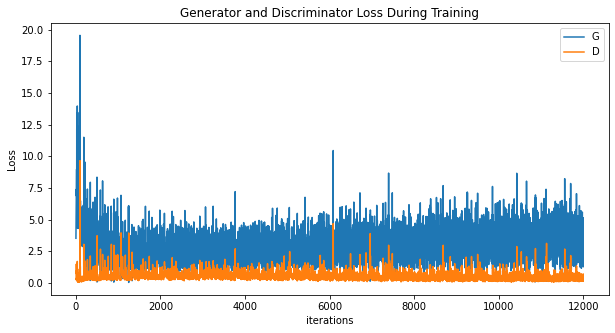

In [37]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

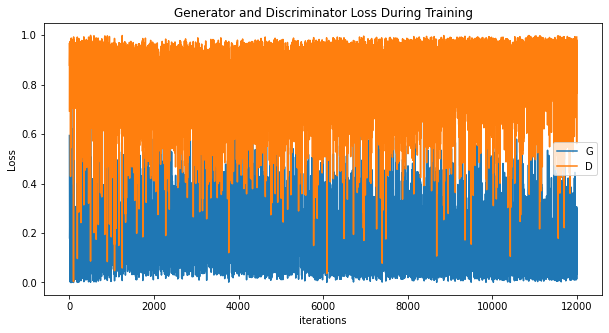

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_G_z1_out,label="G")
plt.plot(D_x_out,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()